In [59]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

import scipy
import pywt
import mne

import sys
from tqdm import tqdm


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import *
from wavelet_utils import *
import glob
import os


#import seaborn as sns
import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [60]:
task = 'motor'

###### CHOOSE SUBJECTS
good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()

#subjects_to_process = find_existing_subjects(task = task, period = 'pre',erp_window=erp_window,freq_high=freq_high) #subs that exist in pre should exist in post
#subjects_to_process = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']
subjects_to_process = good_motor_subjects
##### CHOOSE CHANNELS
ch_to_process = 'mean'
#ch_to_process = ch_index(['Cz'])



wavelet_params = {
    'fs' :128 , # example sampling frequency in Hz
    'centerfreq' : 1 ,
    'bandwidth': 1.5,
    'level': 10,
    'scale_values':[6, 150, 40]
}

epochs_dir = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_{task}/{task}_mTRF_data_30Hz'
wavelet_dir = f"./wavelet_{task}_mean"

print('processing subjects:', subjects_to_process)
print('processing channels:', ch_to_process)

mne.set_log_level('CRITICAL')

processing subjects: ['01', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '18', '19', '20']
processing channels: mean


## Batch processing wavelets

In [71]:
def wavelet_batch_mtrf(subjects_to_process, channels, ep_dir, output_dir, wavelet_params, ave = False, overwrite = False, erp_begin = -0.5, erp_end = 0.5):

    """
    wavelet transforms epochs trial by trial for each subject

    
    subjects_to_process: list of subjects
    channels: 'all' or a list of channels. If not all, will only save the wavelet transformed channels and others are discarded
    ep_dir: directory where epochs are saved
    output_dir: dir to save wavelet data
    wavelet_params: dict with wavelet parameters. Example:
        wavelet_params = {
                'fs' :128 , # example sampling frequency in Hz
                'centerfreq' : 5 ,
                'bandwidth': 1.5,
                'level': 10,
                'scale_values':[6, 150, 40]
            }

    ave: whether to average spectrograms all the trials before saving (TO IMPLEMENT)

     ----
    saves wavelet transforms to .mat files
    'wavelet': wavelet data of dim n_trials x n_channels x spect_freqs x spect_times
    """
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

    times = create_erp_times(erp_begin, erp_end, 128)

    for mtrf_name in sorted(os.listdir(ep_dir)):

    #identify subject
        subject_id = mtrf_name.split("_")[-1].split(".")[0]
        if subject_id not in subjects_to_process:
            print(f'subject {subject_id} not in subjects to process. skipping...')
            continue
    
        
        mat_name = mtrf_name.split(".")[0].replace("weights", "_wavelet")
        mat_path = os.path.join(output_dir, f"{mat_name}.mat")


        if not os.path.exists(mat_path) or overwrite: #skip if the file already exists
            print('processing', mtrf_name)
            
            #get data to loop over
            epochs_data = loadmat(os.path.join(ep_dir, mtrf_name))['weights']
            n_trials = epochs_data.shape[0]
       
            wavelet_data = []
            #for trial in range(10):
            for trial in tqdm(range(n_trials)):
                
                #initiate storage matrix
                n_freqs = wavelet_params['scale_values'][2]
                n_times = times.shape[0]
                if isinstance(channels, str):
                    if channels == 'all':
                        trial_wavelet = np.zeros((64, n_freqs, n_times))
                        ch_towav = np.arange(64) 
                    elif channels == 'mean':
                        trial_wavelet = np.zeros((1, n_freqs, n_times))
                        ch_towav = np.arange(1)
                else:
                    trial_wavelet = np.zeros((len(channels), n_freqs, n_times)) 
                    ch_towav = channels

                for j, ch in enumerate(ch_towav):
                    if channels == 'all' or isinstance(channels, list):
                        trial_data = epochs_data[trial, :, ch] #shape is different from epochs 
                    else:
                        trial_data_alltrials = np.mean(epochs_data, axis = 2)
                        trial_data = trial_data_alltrials[trial]
                    
               
                    cwtmatr, freqs, wavelet = morwav_trans(trial_data, 
                                                    centerfreq=wavelet_params['centerfreq'], 
                                                    bandwidth=wavelet_params['bandwidth'], 
                                                    scale_values=wavelet_params['scale_values'])

                    cwtmatr_abs = np.abs(cwtmatr)
                    print(cwtmatr_abs.shape)
                    trial_wavelet[j, :,:] = cwtmatr_abs

                wavelet_data.append(trial_wavelet)

            #save subject data to mat file
            wavelet_data = np.array(wavelet_data)
            wavelet_tosave = {
                'wavelet_transform':wavelet_data
            }

            savemat(mat_path, wavelet_tosave)
    
    #processing record for wavelet
    
    wavelet_record = {
        'freqs': freqs,
        'wavelet': wavelet,
        'subjects': subjects_to_process,
        'centerfreq': wavelet_params['centerfreq'],
        'bandwidth': wavelet_params['bandwidth'],
        'scale_values': wavelet_params['scale_values'],
        'times': times, 
        'channels': channels
    }
    savemat(os.path.join(output_dir, f'wavelet_record.mat'), wavelet_record)



processing mTRFweights_motor_post_01.mat


100%|██████████| 1/1 [00:00<00:00, 61.32it/s]


(40, 129)
processing mTRFweights_motor_post_03.mat


100%|██████████| 1/1 [00:00<00:00, 77.45it/s]


(40, 129)
processing mTRFweights_motor_post_04.mat


100%|██████████| 1/1 [00:00<00:00, 71.84it/s]


(40, 129)
processing mTRFweights_motor_post_05.mat


100%|██████████| 1/1 [00:00<00:00, 84.95it/s]


(40, 129)
processing mTRFweights_motor_post_06.mat


100%|██████████| 1/1 [00:00<00:00, 79.19it/s]


(40, 129)
processing mTRFweights_motor_post_07.mat


100%|██████████| 1/1 [00:00<00:00, 80.94it/s]


(40, 129)
processing mTRFweights_motor_post_08.mat


100%|██████████| 1/1 [00:00<00:00, 79.47it/s]


(40, 129)
processing mTRFweights_motor_post_09.mat


100%|██████████| 1/1 [00:00<00:00, 88.28it/s]


(40, 129)
processing mTRFweights_motor_post_10.mat


100%|██████████| 1/1 [00:00<00:00, 83.28it/s]


(40, 129)
processing mTRFweights_motor_post_11.mat


100%|██████████| 1/1 [00:00<00:00, 91.28it/s]


(40, 129)
processing mTRFweights_motor_post_12.mat


100%|██████████| 1/1 [00:00<00:00, 77.34it/s]


(40, 129)
processing mTRFweights_motor_post_13.mat


100%|██████████| 1/1 [00:00<00:00, 90.91it/s]


(40, 129)
processing mTRFweights_motor_post_14.mat


100%|██████████| 1/1 [00:00<00:00, 86.44it/s]


(40, 129)
processing mTRFweights_motor_post_15.mat


100%|██████████| 1/1 [00:00<00:00, 52.73it/s]

(40, 129)
processing mTRFweights_motor_post_16.mat



100%|██████████| 1/1 [00:00<00:00, 66.66it/s]


(40, 129)
processing mTRFweights_motor_post_18.mat


100%|██████████| 1/1 [00:00<00:00, 88.72it/s]


(40, 129)
processing mTRFweights_motor_post_19.mat


100%|██████████| 1/1 [00:00<00:00, 58.18it/s]


(40, 129)
processing mTRFweights_motor_post_20.mat


100%|██████████| 1/1 [00:00<00:00, 88.50it/s]

(40, 129)
processing mTRFweights_motor_pre_01.mat



100%|██████████| 1/1 [00:00<00:00, 73.91it/s]

(40, 129)


processing mTRFweights_motor_pre_03.mat


100%|██████████| 1/1 [00:00<00:00, 82.43it/s]


(40, 129)
processing mTRFweights_motor_pre_04.mat


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_3565/586872976.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
100%|██████████| 1/1 [00:00<00:00, 76.99it/s]


(40, 129)
processing mTRFweights_motor_pre_05.mat


100%|██████████| 1/1 [00:00<00:00, 91.72it/s]


(40, 129)
processing mTRFweights_motor_pre_06.mat


100%|██████████| 1/1 [00:00<00:00, 73.65it/s]


(40, 129)
processing mTRFweights_motor_pre_07.mat


100%|██████████| 1/1 [00:00<00:00, 85.47it/s]


(40, 129)
processing mTRFweights_motor_pre_08.mat


100%|██████████| 1/1 [00:00<00:00, 84.77it/s]


(40, 129)
processing mTRFweights_motor_pre_09.mat


100%|██████████| 1/1 [00:00<00:00, 84.90it/s]


(40, 129)
processing mTRFweights_motor_pre_10.mat


100%|██████████| 1/1 [00:00<00:00, 86.45it/s]


(40, 129)
processing mTRFweights_motor_pre_11.mat


100%|██████████| 1/1 [00:00<00:00, 89.36it/s]

(40, 129)


processing mTRFweights_motor_pre_12.mat


100%|██████████| 1/1 [00:00<00:00, 84.18it/s]

(40, 129)


processing mTRFweights_motor_pre_13.mat


100%|██████████| 1/1 [00:00<00:00, 80.42it/s]


(40, 129)
processing mTRFweights_motor_pre_14.mat


100%|██████████| 1/1 [00:00<00:00, 69.01it/s]

(40, 129)
processing mTRFweights_motor_pre_15.mat



100%|██████████| 1/1 [00:00<00:00, 52.43it/s]

(40, 129)


processing mTRFweights_motor_pre_16.mat


100%|██████████| 1/1 [00:00<00:00, 54.98it/s]


(40, 129)
processing mTRFweights_motor_pre_18.mat


100%|██████████| 1/1 [00:00<00:00, 68.22it/s]


(40, 129)
processing mTRFweights_motor_pre_19.mat


100%|██████████| 1/1 [00:00<00:00, 52.86it/s]


(40, 129)
processing mTRFweights_motor_pre_20.mat


100%|██████████| 1/1 [00:00<00:00, 87.21it/s]

(40, 129)


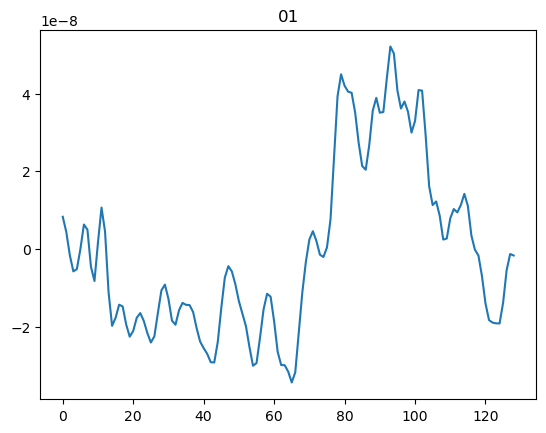

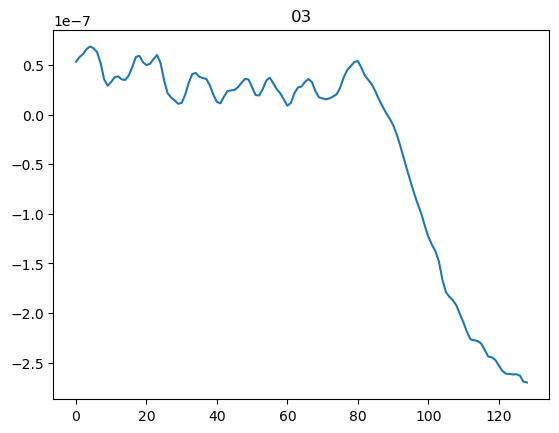

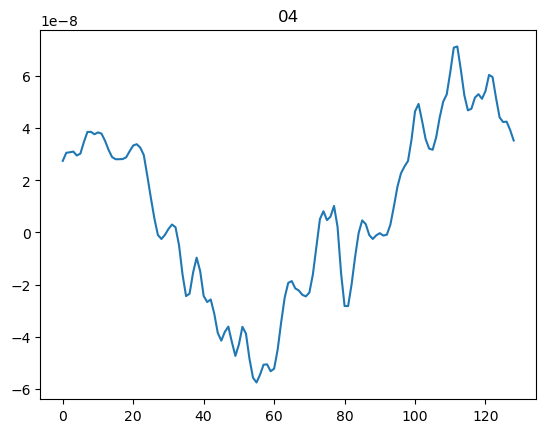

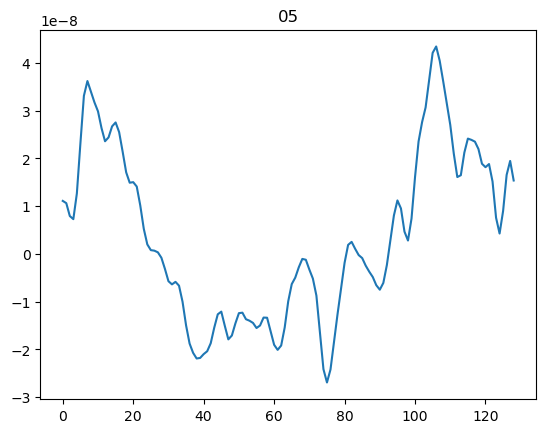

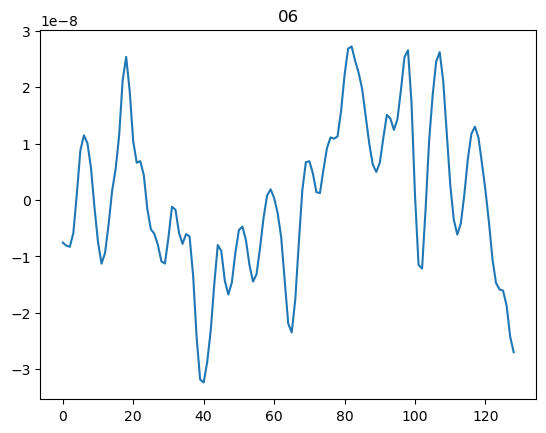

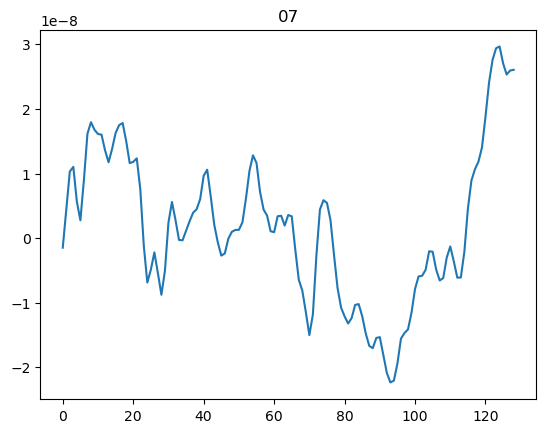

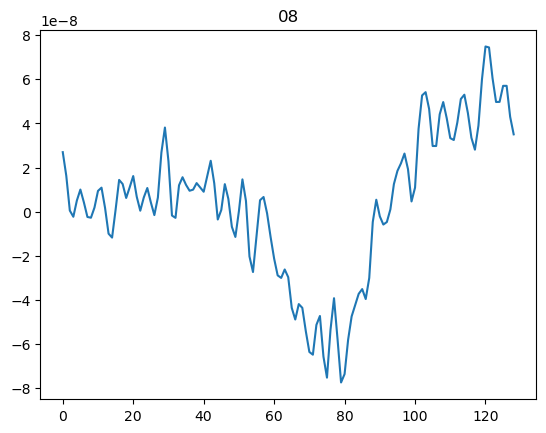

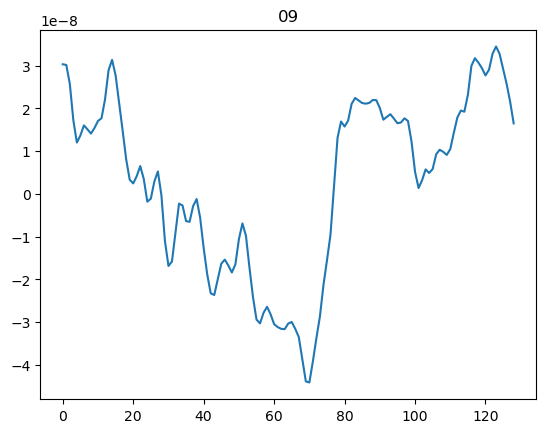

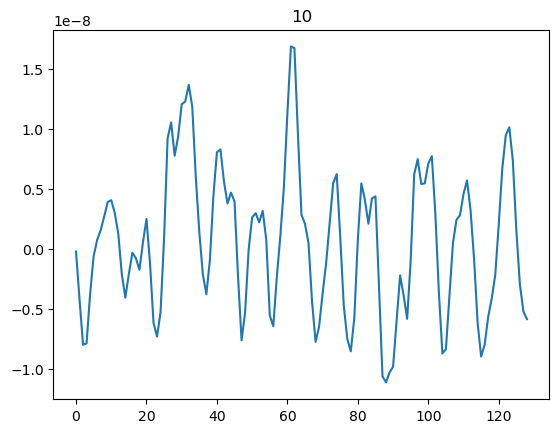

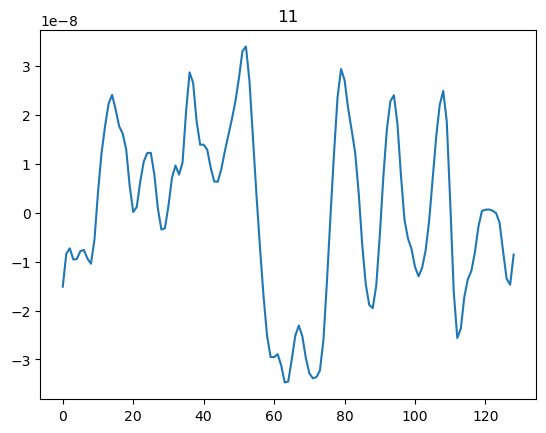

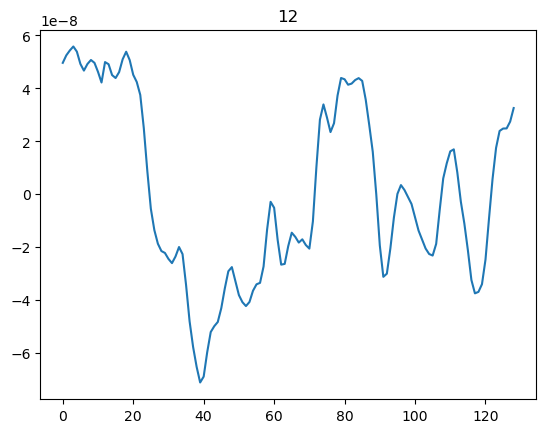

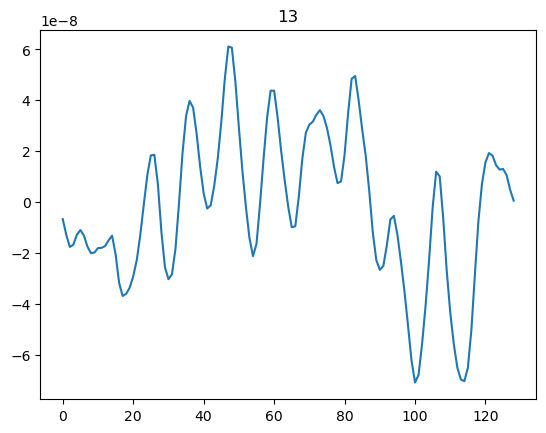

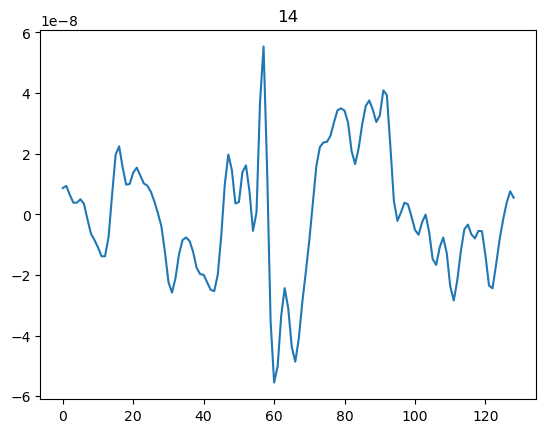

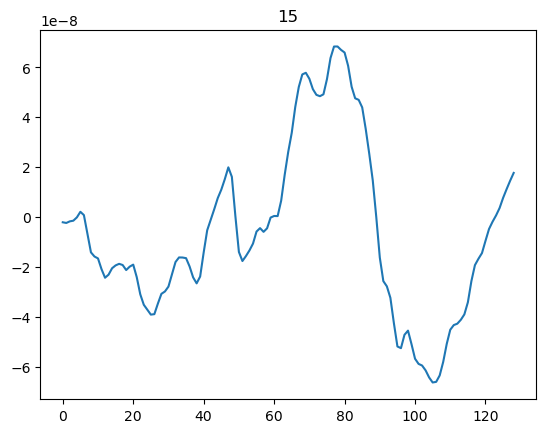

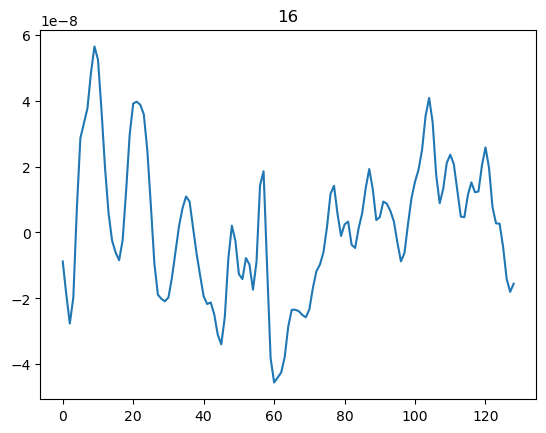

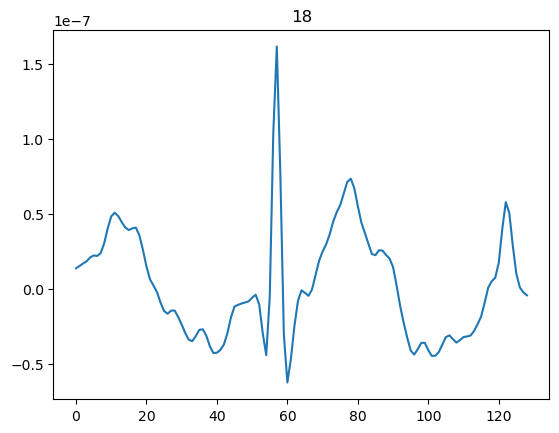

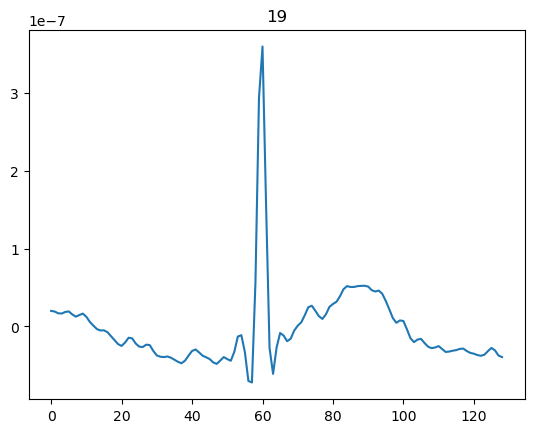

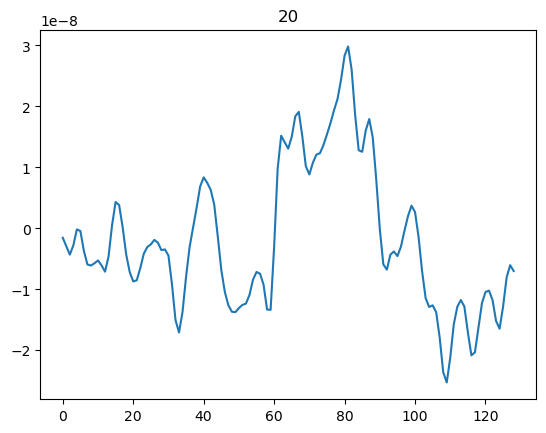

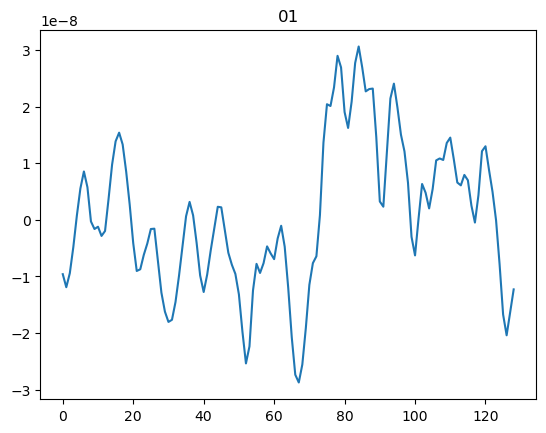

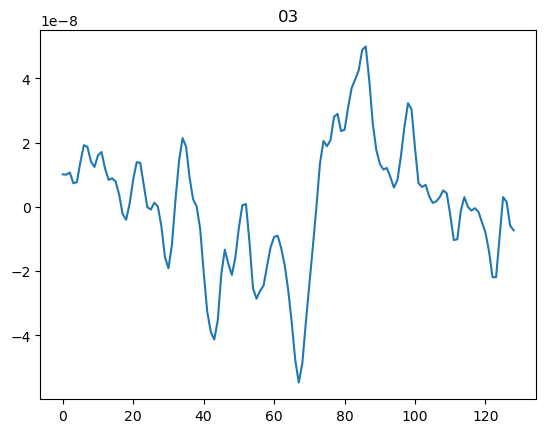

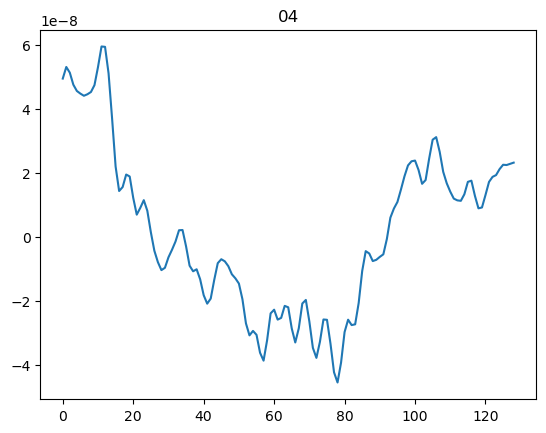

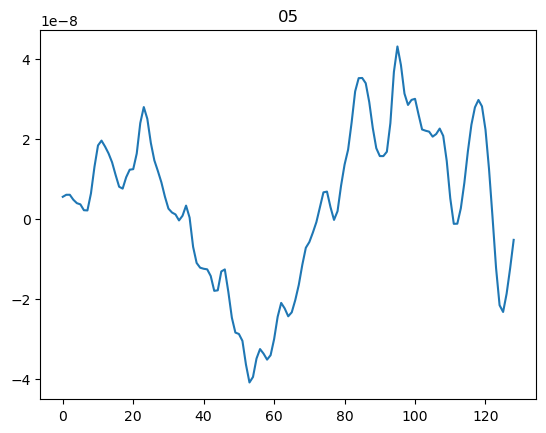

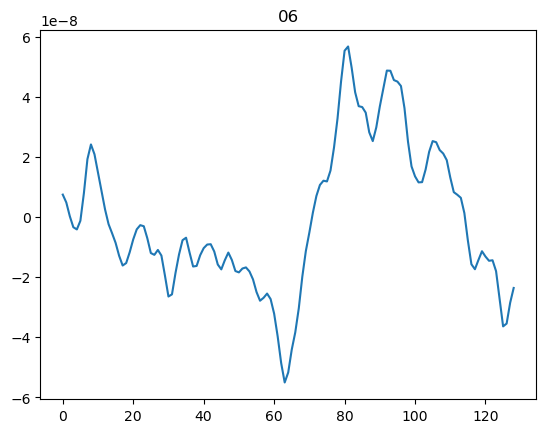

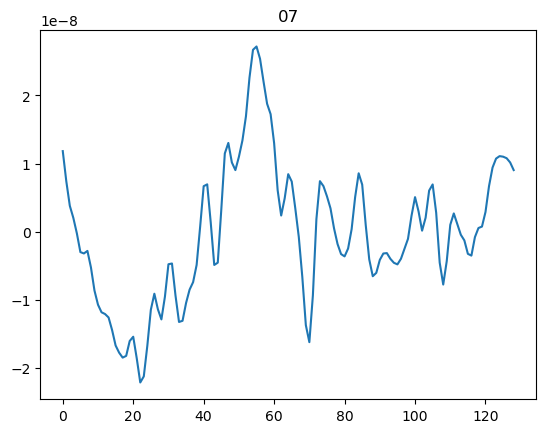

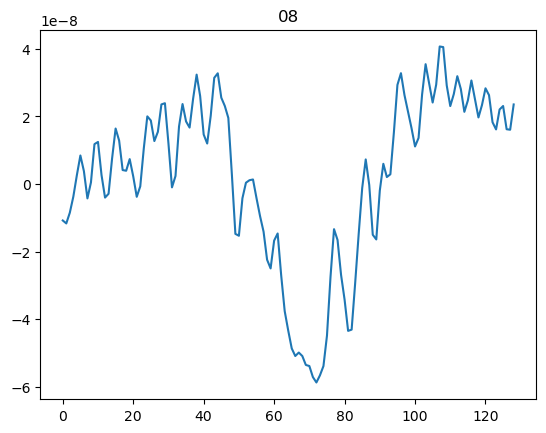

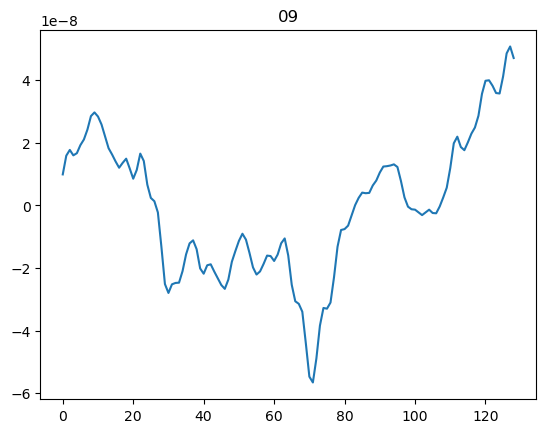

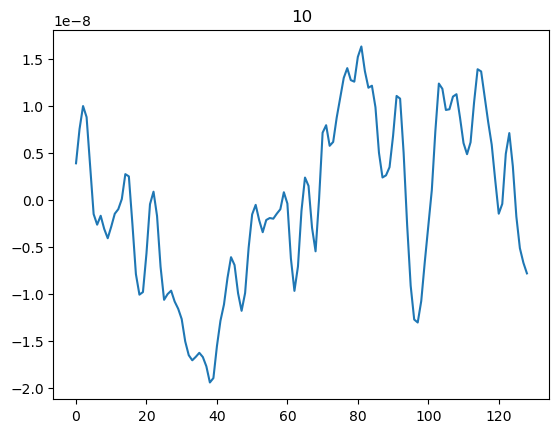

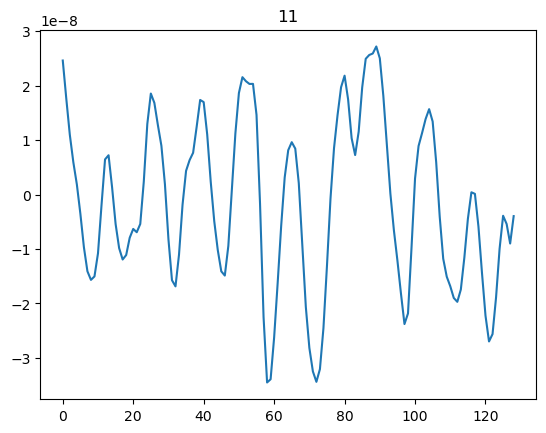

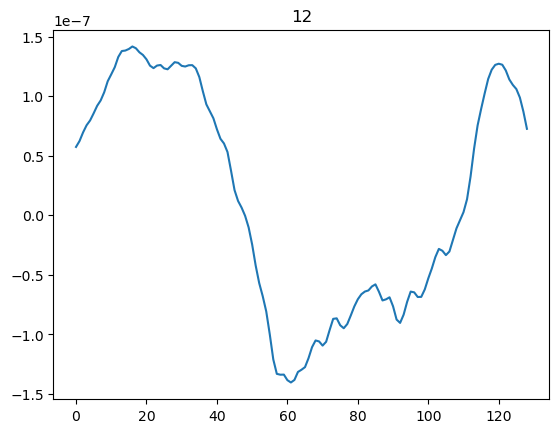

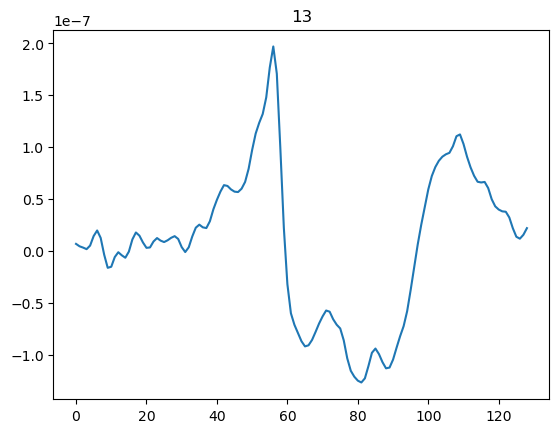

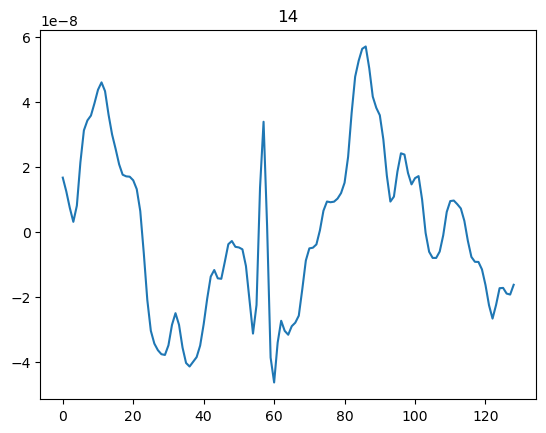

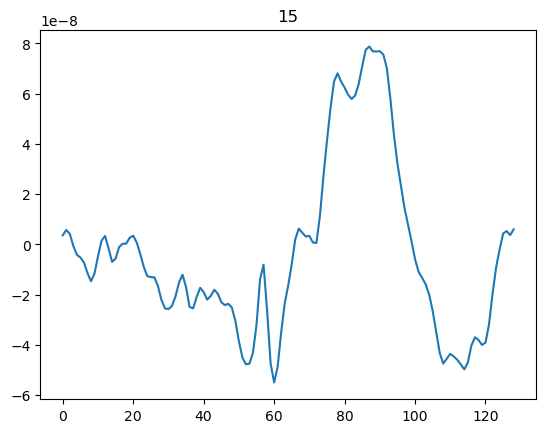

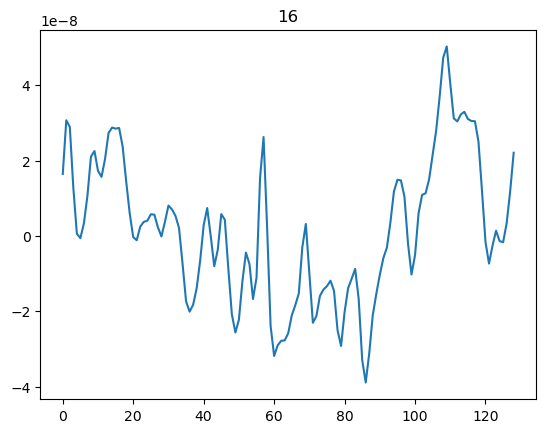

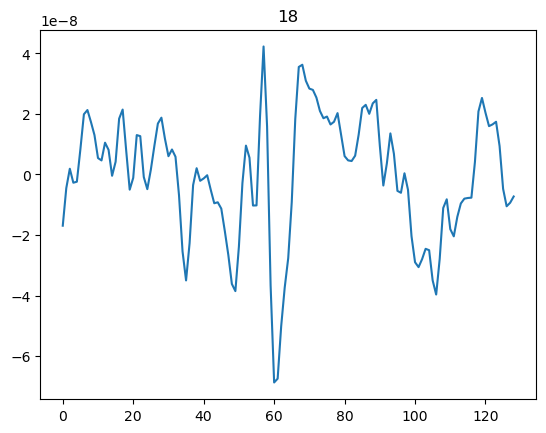

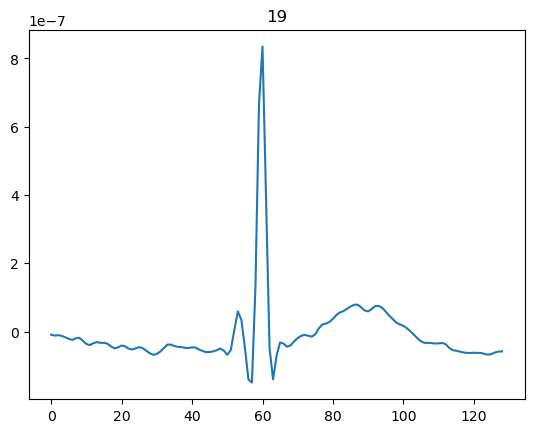

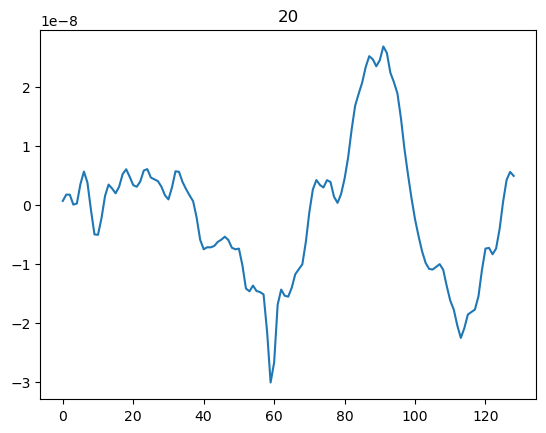

In [72]:
wavelet_batch_mtrf(subjects_to_process, ch_to_process, epochs_dir, wavelet_dir, wavelet_params, overwrite=True)
